In [47]:
import numpy as np
from matplotlib import pyplot as plt

from os import listdir
from os.path import join
from scipy.io import wavfile

import sys
import math

import librosa
import librosa.display
from librosa.effects import trim

import tensorflow as tf
import tensorflow_io as tfio
from tensorflow.keras import preprocessing
from tensorflow.keras import layers
from tensorflow.keras import models
from keras.optimizers import Adam

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix
from scikeras.wrappers import KerasClassifier

import itertools  

import IPython.display as ipd
from IPython.core.display import display
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


/tmp/ipykernel_8154/2100141766.py:30: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


# Util functions

In [48]:
# by default anything below 10 db is considered as silence
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    # Trim the beginning and ending silence
    yt, _ = trim(sample, top_db= top_db)
    return yt

In [49]:
def pad_trunc(aud, max_ms):
    sig, sr = aud
    num_rows, sig_len = sig.shape
    max_len = sr//1000 * max_ms

    if (sig_len > max_len):
      # Truncate the signal to the given length
      sig = sig[:,:max_len]

    elif (sig_len < max_len):
      # Length of padding to add at the beginning and end of the signal
      pad_begin_len = random.randint(0, max_len - sig_len)
      pad_end_len = max_len - sig_len - pad_begin_len

      # Pad with 0s
      pad_begin = torch.zeros((num_rows, pad_begin_len))
      pad_end = torch.zeros((num_rows, pad_end_len))

      sig = torch.cat((pad_begin, sig, pad_end), 1)
      
    return (sig, sr)

In [50]:
def stft_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([max_size] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)

  spectrogram = tf.abs(spectrogram)

  return spectrogram

In [51]:
def mel_spectrogram(waveform):
    spec = librosa.feature.melspectrogram(y=waveform, sr=8000)
    return librosa.power_to_db(spec, ref=np.max)

In [52]:
def mfcc_spectrogram(waveform):
    """Mel-Frequency Cepstral Coefficients (MFCCs)"""
    spec = librosa.feature.mfcc(y=waveform, sr=8000)
    return spec

In [53]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [54]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Reds')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.1f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [55]:
def get_white_noise(signal,SNR) :
    RMS_s=math.sqrt(np.mean(signal.astype(np.int32)**2))
    RMS_n=math.sqrt(RMS_s**2/(pow(10,SNR/10)))
    STD_n=RMS_n
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

In [56]:
def add_noise(data):  
    newdata = []
    for audio in data:
        noise = get_white_noise(audio, 3)
        newdata.append(audio + noise)
    
    return newdata

In [57]:
def change_pitch(data): 
    newdata = []
    for audio in data:
        newdata.append(librosa.effects.pitch_shift(audio.astype(np.float64), sr=8000, n_steps=3))
    
    return newdata

In [58]:
def stretch(data): 
    newdata = []
    for audio in data:
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), rate=0.5) ) 
        newdata.append( librosa.effects.time_stretch(audio.astype(np.float64), rate=1.4) )
    
    return newdata

In [59]:
def data_augmentation(X, y, *, noise=False, pitch=False, time_stretch=False):
    X2 = [*X]
    y2 = [*y]
    display(ipd.Audio(X2[-1], rate=8000))
    
    if pitch:
        print('Pitch')
        X2 += change_pitch(X)
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Pitch Shift")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
      
    if time_stretch:
        print('Time Stretch')
        X2 += stretch(X)
        y2 += 2*y
        display(ipd.Audio(X2[-len(X) - 1], rate=8000))
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[-len(X) + inv_longest_audio])
        plt.title("Longest audio signal after Time Stretch of x0.5")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Time Stretch of x1.4")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")#X = np.array([time_mask(freq_mask(x)) for x in X])
        plt.show()
        
    if noise:
        print('Noise')
        X2 += add_noise(X) 
        y2 += y
        display(ipd.Audio(X2[-1], rate=8000))
        
        plt.plot(X2[inv_longest_audio])
        plt.title("Longest audio signal after Adding Noise")
        plt.xlabel("Time")
        plt.ylabel("Amplitude")
        plt.show()
        
    return X2, y2

In [60]:
def freq_mask(spec):
    return tfio.audio.freq_mask(spec, param=4).numpy()

In [61]:
def time_mask(spec):
    return tfio.audio.time_mask(spec, param=4).numpy()

# Data Setup

## Get the audio files

In [62]:
files = 'recordings/'
ds_files = listdir(files)

labels = [str(i) for i in range(10)]
rate = 8000

X = []
y = []

for file in ds_files:
    label = int(file.split("_")[0])
    rate, data = wavfile.read(join(files, file))
    
    X.append(data.astype(float))
    y.append(label)
    

min_size = 100000
for x in X:
    min_size = min(min_size, x.shape[0])
print(min_size)


1148


# Data Augmentation

Augment the data, by stretching it, adding white noise, and pitch shifting it.

Pitch


/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1933
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1399
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1876
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1983
  warnings.warn(
/home/leikrad/Projects/TAA/TAA_Projects/project_2/.venv/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2033
  warnings.w

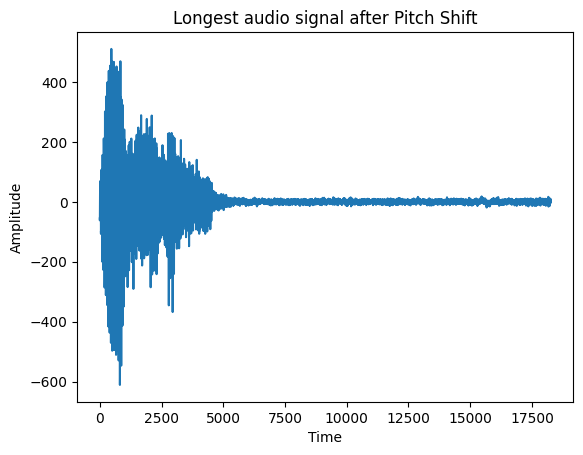

Time Stretch


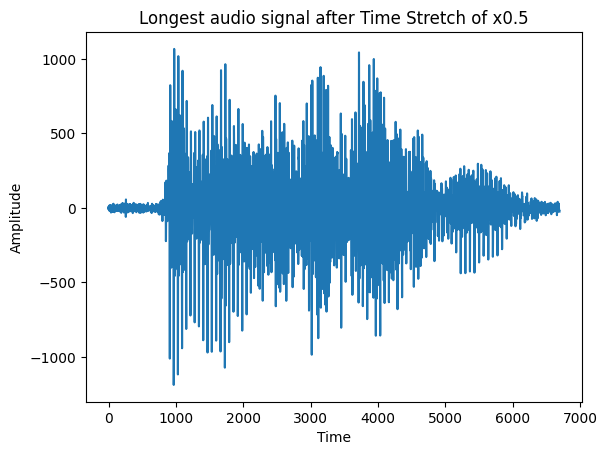

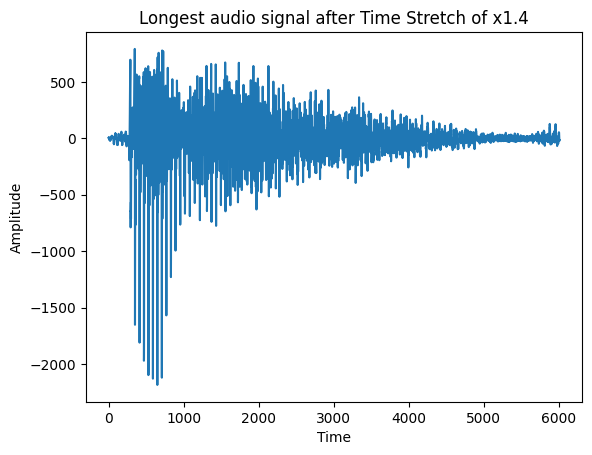

Noise


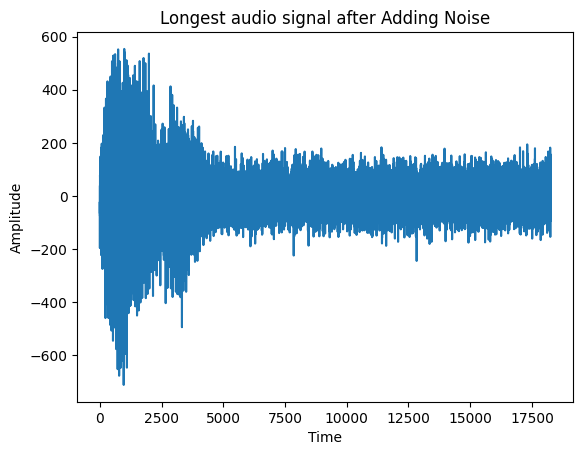

15000 15000


In [63]:
inv_longest_audio = - (len(X) - np.argmax([len(x) for x in X]))

X, y = data_augmentation(X, y, noise=True, pitch=True, time_stretch=True)

print(len(X), len(y))

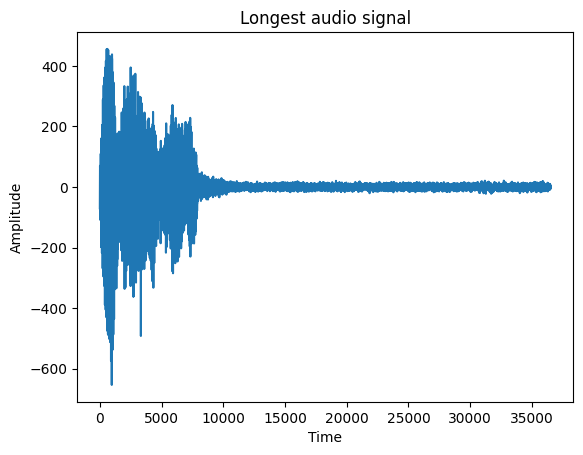

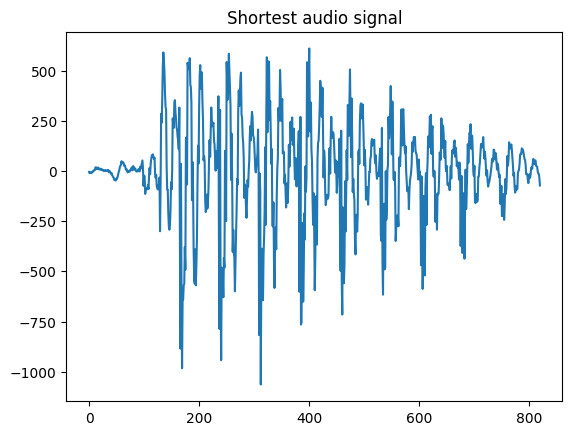

Max sizing before: 36524
Max sizing after: 12800


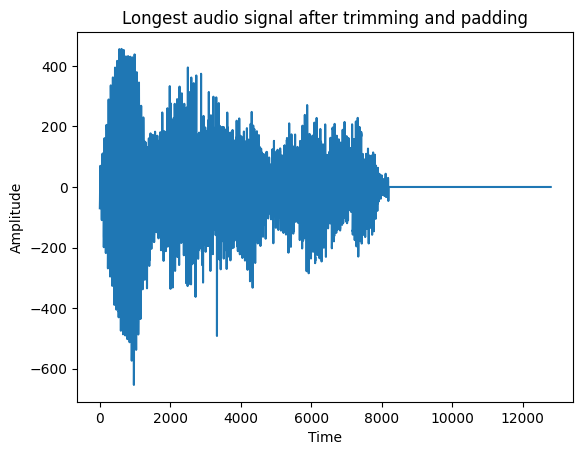

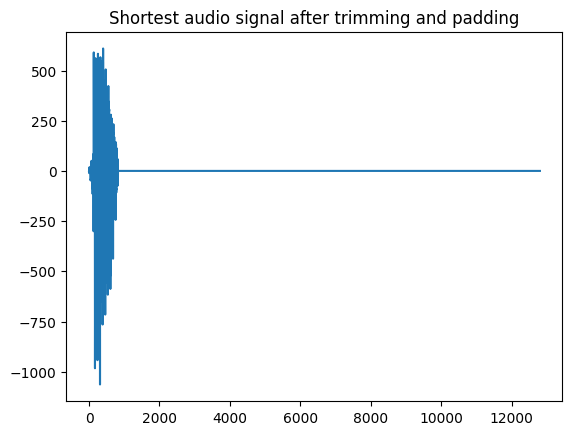

In [64]:
longest_audio = np.argmax([len(x) for x in X])
plt.plot(X[longest_audio])
plt.title("Longest audio signal")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

shortest_audio = np.argmin([len(x) for x in X])
plt.plot(X[shortest_audio])
plt.title("Shortest audio signal")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))


max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing before:', max_size)

# trim silence
X = [ remove_silence(x) for x in X ]


# add padding to max size
max_size = 0
for x in X:
    max_size = max(max_size, x.shape[0])
    
print('Max sizing after:', max_size)
    
X = [ np.pad(x, (0, max_size - x.shape[0])) for x in X ]

plt.plot(X[longest_audio])
plt.title("Longest audio signal after trimming and padding")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.show()

display(ipd.Audio(X[longest_audio], rate=rate))

plt.plot(X[shortest_audio])
plt.title("Shortest audio signal after trimming and padding")
plt.show()

display(ipd.Audio(X[shortest_audio], rate=rate))

(128, 26)
(20, 26)


[Text(0.5, 1.0, 'MFCC Spectrogram with Freq. and Time Mask')]

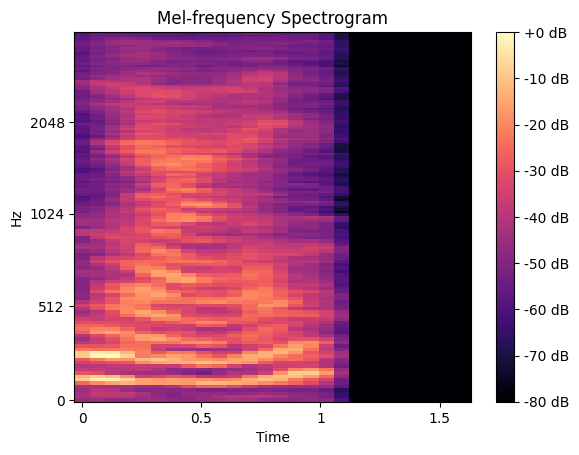

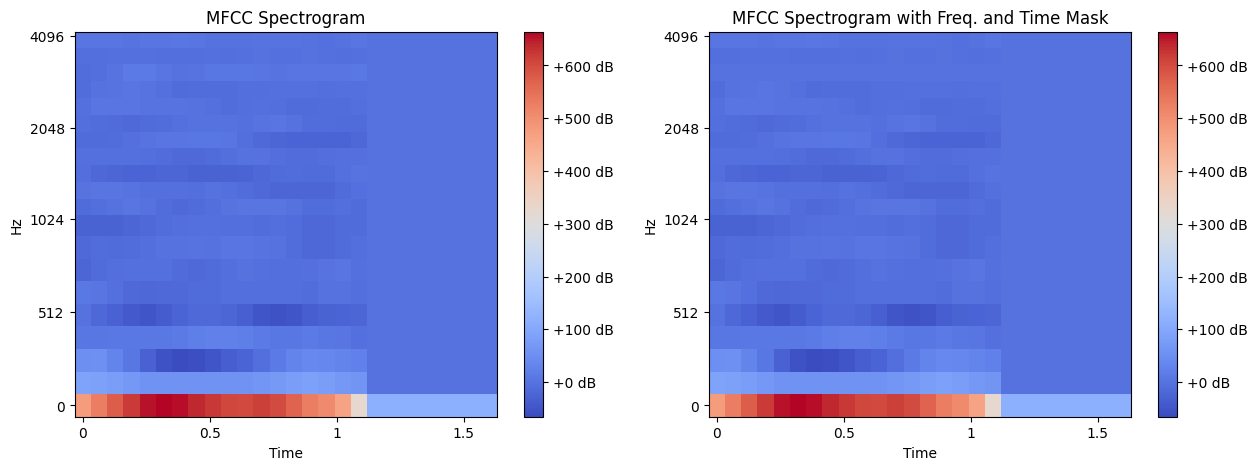

In [65]:
#librosa.feature.mfcc(y_cut, n_fft=n_fft, hop_length=512,n_mfcc=128)

#spec = librosa.stft(X[1500])

wave = X[longest_audio]

S = mel_spectrogram(wave)
print(S.shape)

fig, ax = plt.subplots()

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency Spectrogram')



S = mfcc_spectrogram(wave)
print(S.shape)


fig, ax = plt.subplots(1,2)

img = librosa.display.specshow(S, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax[0])
fig.colorbar(img, ax=ax[0], format='%+2.0f dB')
ax[0].set(title='MFCC Spectrogram')


S2 = freq_mask(time_mask(S))

#fig, ax = plt.subplots()

img = librosa.display.specshow(S2, x_axis='time',
                         y_axis='mel', sr=rate, ax=ax[1])

fig.colorbar(img, ax=ax[1], format='%+2.0f dB')
fig.set_size_inches(15, 5)
ax[1].set(title='MFCC Spectrogram with Freq. and Time Mask')


(99, 129)


/tmp/ipykernel_8154/2306894922.py:4: RuntimeWarning: divide by zero encountered in log
  log_spec = np.log(spectrogram.T)


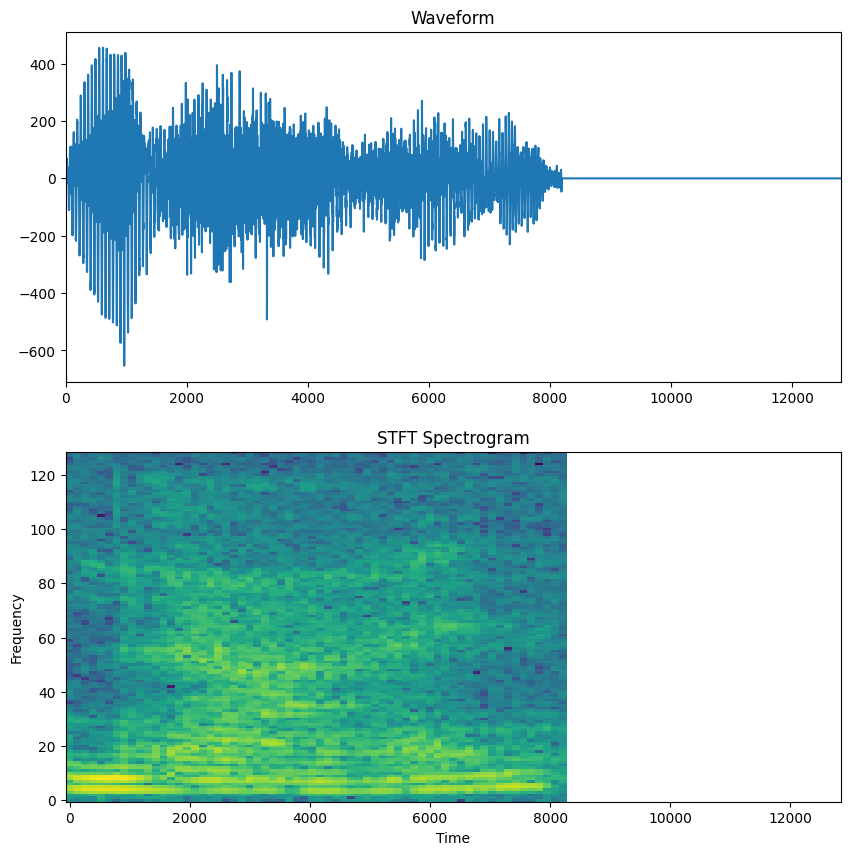

In [66]:
waveform = X[longest_audio]

spectrogram = stft_spectrogram(waveform).numpy()

#spectrogram.resize(32, 32)
print(spectrogram.shape)

timescale = np.arange(waveform.shape[0])
fig, axes = plt.subplots(2, figsize=(12, 8))
axes[0].plot(timescale, waveform)
axes[0].set_title('Waveform')
axes[0].set_xlim([0, max_size])

fig.set_size_inches(10, 10)

axes[1].set_xlabel('Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('STFT Spectrogram')

plot_spectrogram(spectrogram, axes[1])


In [67]:
# try different spec
X = np.array([mfcc_spectrogram(x) for x in X])


In [68]:
train_ratio = 0.60
validation_ratio = 0.20
test_ratio = 0.20

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

print(len(x_train), len(x_val), len(x_test))

x_train_cur = x_train
x_val_cur = x_val
x_test_cur = x_test

9000 3000 3000


In [69]:
input_shape = x_train_cur.shape
num_labels = 10

print(input_shape)


model = models.Sequential([
    layers.Input(shape=(*x_train_cur[0].shape, 1)),
    layers.Resizing(32, 32),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    #layers.Conv2D(64, 3, activation='relu'),
    #layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()

# 97 1 1 0.2
# 97 1 1 0.5

(9000, 20, 26)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       921,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 923,338 (3.52 MB)

 Trainable params: 923,338 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [70]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [71]:
EPOCHS = 75
history = model.fit(
    x_train_cur, 
    np.array(y_train),
    validation_data=(x_val_cur, np.array(y_val)),  
    epochs=EPOCHS
)

Epoch 1/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.1204 - loss: 8.8243 - val_accuracy: 0.1243 - val_loss: 2.2770
Epoch 2/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.1501 - loss: 2.2270 - val_accuracy: 0.2600 - val_loss: 2.0412
Epoch 3/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2736 - loss: 2.0026 - val_accuracy: 0.3873 - val_loss: 1.7000
Epoch 4/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3810 - loss: 1.6786 - val_accuracy: 0.4600 - val_loss: 1.4094
Epoch 5/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4908 - loss: 1.3544 - val_accuracy: 0.5643 - val_loss: 1.1506
Epoch 6/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5429 - loss: 1.2148 - val_accuracy: 0.6073 - val_loss: 1.0423
Epoch 7/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.5973 - loss: 1.0783 - val_accuracy: 0.6367 - val_loss: 0.9539
Epoch 8/75
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.6333 - loss: 0.9937 - val_accu

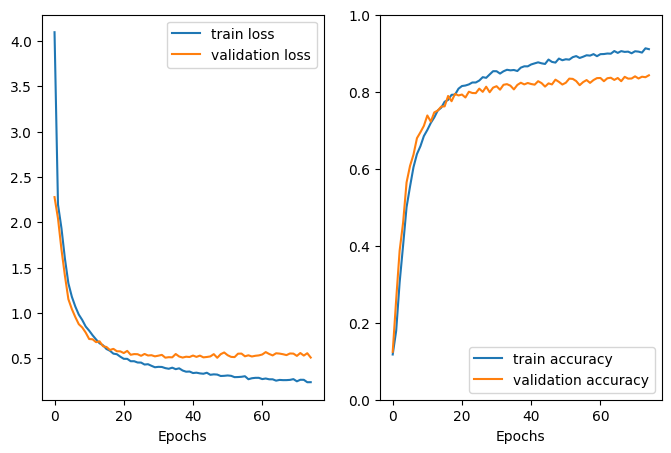

In [72]:
metrics = history.history


fig, ax = plt.subplots(1, 2)

ax[0].plot(history.epoch, metrics['loss'], metrics['val_loss'])
ax[0].set_xlabel('Epochs')
ax[0].legend(['train loss', 'validation loss'])


ax[1].plot(history.epoch, metrics['accuracy'], metrics['val_accuracy'])
#plt.plot([x + 25 for x in history.epoch], metrics['accuracy'])
#plt.plot([x + 25 for x in history.epoch], metrics['val_accuracy'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylim([0, 1])
ax[1].legend(['train accuracy', 'validation accuracy'])

fig.set_size_inches(8, 5)
plt.show()



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


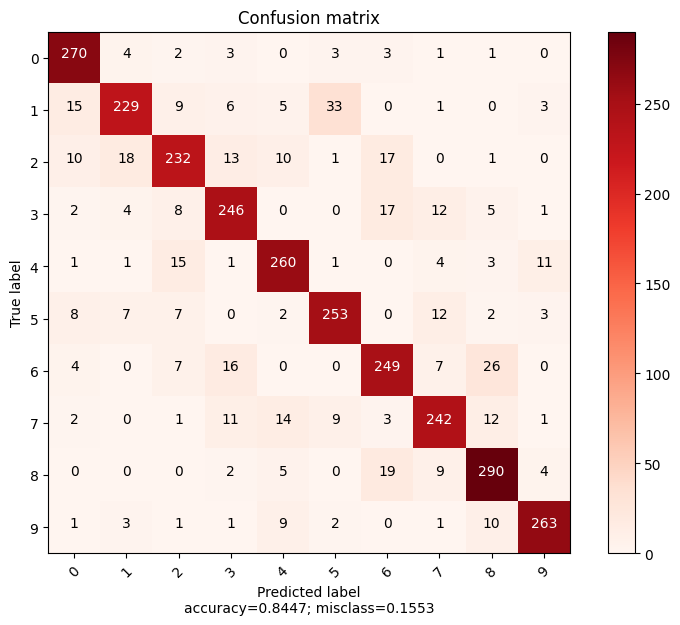

In [73]:
y_pred = model.predict(x_test_cur)

predicted_categories = tf.argmax(y_pred, axis=1)

true_categories = y_test

cm = confusion_matrix(true_categories,predicted_categories)
plot_confusion_matrix(cm, labels, normalize=False)


Classification Report

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       287
           1       0.86      0.76      0.81       301
           2       0.82      0.77      0.79       302
           3       0.82      0.83      0.83       295
           4       0.85      0.88      0.86       297
           5       0.84      0.86      0.85       294
           6       0.81      0.81      0.81       309
           7       0.84      0.82      0.83       295
           8       0.83      0.88      0.85       329
           9       0.92      0.90      0.91       291

    accuracy                           0.84      3000
   macro avg       0.85      0.85      0.84      3000
weighted avg       0.84      0.84      0.84      3000



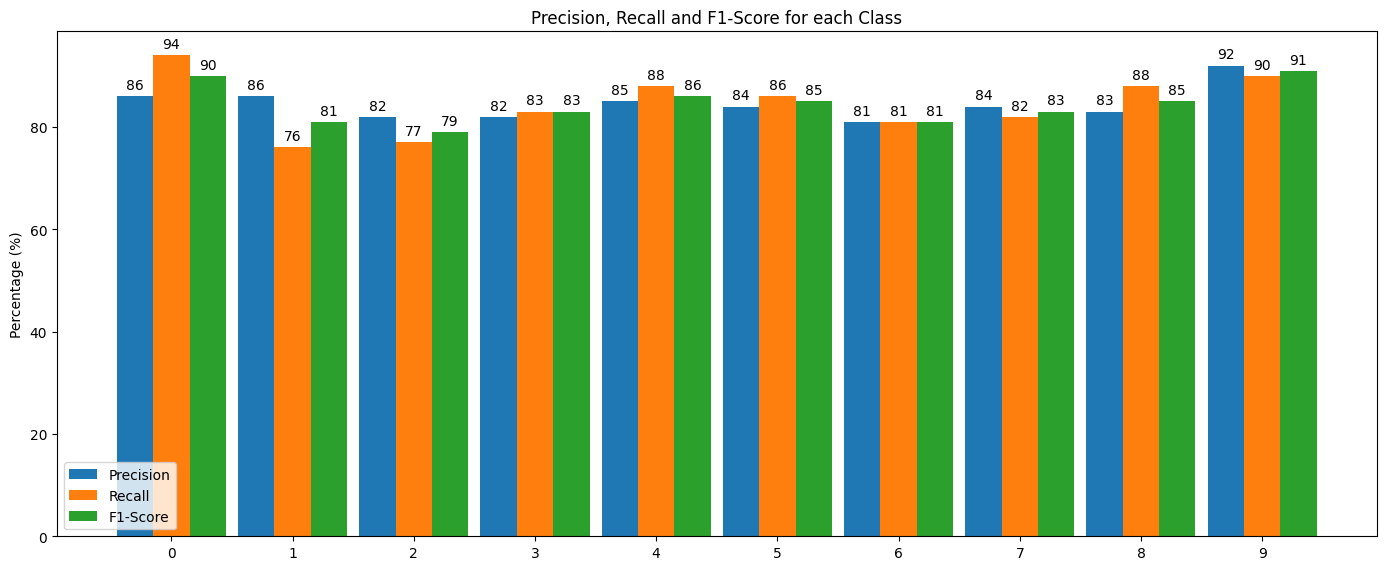

In [74]:
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score
print('\nClassification Report\n')

cr = classification_report(true_categories, predicted_categories)
print(cr)


precision_score = np.round(precision_score(true_categories, predicted_categories, average=None),2)
recall_score = np.round(recall_score(true_categories, predicted_categories, average=None),2)
f1_score = np.round(f1_score(true_categories, predicted_categories, average=None),2)

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars


fig, ax = plt.subplots()
rects1 = ax.bar(x - width, precision_score*100, width, label='Precision')
rects2 = ax.bar(x , recall_score*100, width, label='Recall')
rects3 = ax.bar(x + width, f1_score*100, width, label='F1-Score')
 
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage (%)')
ax.set_title('Precision, Recall and F1-Score for each Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)

fig.tight_layout()
fig.set_size_inches(15, 6, forward=True)
plt.show()